# XG Boost Model Implementation for NYSE Stock Dataset

In [ ]:
# install the xgboost
!pip install xgboost

Read the processed data  (stored in the parquet format)

In [1]:
# importing the core libraries
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
# Read the parquet file
main_df = pd.read_parquet("../data/processed/price_features.parquet")

# display the df
main_df

,date,symbol,open,close,low,high,volume,close_lag1,log_return_1d,target_next_day_return,...,rolling_mean_5,rolling_mean_10,rolling_std_5,rolling_std_10,momentum_5,momentum_10,volume_change_1d,volume_zscore_10,high_low_ratio,close_open_ratio
0,2010-01-19,A,21.716737,22.031474,21.709585,22.052933,3563600.0,21.766810,0.012086,-0.005535,...,21.962804,22.014306,0.210961,0.153942,0.003127,0.000780,-0.229758,-0.405386,1.015815,1.014493
1,2010-01-20,A,21.838340,21.909872,21.595137,21.938484,4589000.0,22.031474,-0.005535,-0.003598,...,21.988555,21.990701,0.190062,0.149553,-0.003578,-0.003676,0.287743,0.571001,1.015899,1.003275
2,2010-01-21,A,22.174536,21.831188,21.587982,22.253220,6081400.0,21.909872,-0.003598,-0.045241,...,21.964235,21.967096,0.203115,0.154671,-0.006057,-0.006187,0.325212,1.536435,1.030815,0.984516
3,2010-01-22,A,21.709585,20.865522,20.808298,21.709585,4263000.0,21.831188,-0.045241,0.009553,...,21.680973,21.849786,0.466406,0.378012,-0.037611,-0.045047,-0.299010,-0.134568,1.043314,0.961120
4,2010-01-25,A,21.044350,21.065809,20.908441,21.208870,3608500.0,20.865522,0.009553,-0.005448,...,21.540773,21.753219,0.534536,0.444022,-0.022050,-0.031600,-0.153530,-0.719029,1.014369,1.001020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845744,2016-12-22,ZTS,52.669998,53.259998,52.669998,53.369999,1515800.0,53.119999,0.002632,0.009716,...,52.865999,52.134999,0.408019,0.928706,0.007453,0.021579,-0.449720,-1.441778,1.013290,1.011202
845745,2016-12-23,ZTS,53.200001,53.779999,53.180000,53.779999,1942400.0,53.259998,0.009716,-0.001116,...,53.129999,52.323999,0.496991,1.056789,0.012234,0.027827,0.281436,-0.983389,1.011282,1.010902
845746,2016-12-27,ZTS,53.779999,53.720001,53.650002,54.150002,1345000.0,53.779999,-0.001116,-0.005226,...,53.395999,52.603999,0.329667,1.013511,0.006068,0.021215,-0.307558,-1.216227,1.009320,0.998884
845747,2016-12-28,ZTS,53.759998,53.439999,53.349998,53.849998,1241900.0,53.720001,-0.005226,0.003363,...,53.463999,52.842999,0.285448,0.879243,-0.000449,0.011298,-0.076654,-1.202686,1.009372,0.994048


After creating some engineered features, these can produce inf or very large values if input data contains zero or missing values. So we need proper cleaning step after feature creation and before model training. So check the data from the raw dataset features and the engineered features that we will use to train the model.

In [62]:
numeric_cols = main_df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    print(col, main_df[col].min(), main_df[col].max())

open 4.65 942.1905120001436
close 4.65 940.2285895620696
low 4.55 937.0227115620576
high 4.73 951.1028761625575
volume 114200.0 161543769.0752033
close_lag1 4.65 940.0782628375263
log_return_1d -0.10024304194133077 0.0937246519672455
target_next_day_return -0.10024304194133077 0.0937246519672455
price_up_tomorrow 0 1
log_return_lag1 -0.10024304194133077 0.0937246519672455
log_return_lag2 -0.10024304194133077 0.0937246519672455
log_return_lag3 -0.10024304194133077 0.09380574286922705
rolling_mean_5 4.656000000000001 942.5233136753421
rolling_mean_10 4.643745984000001 941.6774007647982
rolling_std_5 0.03097170325848673 17.58946090310142
rolling_std_10 0.058585170669555195 23.621475387853028
momentum_5 -0.10373435761106202 0.09657333008927843
momentum_10 -0.1468243424844179 0.13752521249750096
volume_change_1d -0.7906089768886402 5.362104979495201
volume_zscore_10 -2.1722876166086955 2.8157452461770456
high_low_ratio 1.0045609691201105 1.1306663516871183
close_open_ratio 0.929085365452059

Found that there are very large values and infinite values in the engineered features. 

So we need to clean the data for training the Xgboost model. Especially remove those engineered features or entries with larges or inf values. And also check for features that are overfitting.

In [ ]:
# replace inf
main_df = main_df.replace([np.inf, -np.inf], np.nan)

In [ ]:
# Remove rows where rolling std = 0
for col in ['rolling_std_5', 'rolling_std_10']:
    if col in main_df.columns:
        main_df = main_df[main_df[col] != 0]

In [ ]:
# Winsorize extreme values
for col in main_df.select_dtypes(include=[np.number]).columns:
    low, high = main_df[col].quantile([0.001, 0.999])
    main_df[col] = main_df[col].clip(lower=low, upper=high)

In [ ]:
# Drop any remaining NaNs
main_df = main_df.dropna()

In [ ]:
# define the target feature
main_df["target"] = main_df['price_up_tomorrow']

,date,symbol,open,close,low,high,volume,close_lag1,log_return_1d,target_next_day_return,...,rolling_mean_10,rolling_std_5,rolling_std_10,momentum_5,momentum_10,volume_change_1d,volume_zscore_10,high_low_ratio,close_open_ratio,target
0,2010-01-19,A,21.716737,22.031474,21.709585,22.052933,3563600.0,21.766810,0.012086,-0.005535,...,22.014306,0.210961,0.153942,0.003127,0.000780,-0.229758,-0.405386,1.015815,1.014493,0
1,2010-01-20,A,21.838340,21.909872,21.595137,21.938484,4589000.0,22.031474,-0.005535,-0.003598,...,21.990701,0.190062,0.149553,-0.003578,-0.003676,0.287743,0.571001,1.015899,1.003275,0
2,2010-01-21,A,22.174536,21.831188,21.587982,22.253220,6081400.0,21.909872,-0.003598,-0.045241,...,21.967096,0.203115,0.154671,-0.006057,-0.006187,0.325212,1.536435,1.030815,0.984516,0
3,2010-01-22,A,21.709585,20.865522,20.808298,21.709585,4263000.0,21.831188,-0.045241,0.009553,...,21.849786,0.466406,0.378012,-0.037611,-0.045047,-0.299010,-0.134568,1.043314,0.961120,1
4,2010-01-25,A,21.044350,21.065809,20.908441,21.208870,3608500.0,20.865522,0.009553,-0.005448,...,21.753219,0.534536,0.444022,-0.022050,-0.031600,-0.153530,-0.719029,1.014369,1.001020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845744,2016-12-22,ZTS,52.669998,53.259998,52.669998,53.369999,1515800.0,53.119999,0.002632,0.009716,...,52.134999,0.408019,0.928706,0.007453,0.021579,-0.449720,-1.441778,1.013290,1.011202,1
845745,2016-12-23,ZTS,53.200001,53.779999,53.180000,53.779999,1942400.0,53.259998,0.009716,-0.001116,...,52.323999,0.496991,1.056789,0.012234,0.027827,0.281436,-0.983389,1.011282,1.010902,0
845746,2016-12-27,ZTS,53.779999,53.720001,53.650002,54.150002,1345000.0,53.779999,-0.001116,-0.005226,...,52.603999,0.329667,1.013511,0.006068,0.021215,-0.307558,-1.216227,1.009320,0.998884,0
845747,2016-12-28,ZTS,53.759998,53.439999,53.349998,53.849998,1241900.0,53.720001,-0.005226,0.003363,...,52.842999,0.285448,0.879243,-0.000449,0.011298,-0.076654,-1.202686,1.009372,0.994048,1


In [ ]:
# list all the columns in the df
main_df.columns

Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume',
       'close_lag1', 'log_return_1d', 'target_next_day_return',
       'price_up_tomorrow', 'log_return_lag1', 'log_return_lag2',
       'log_return_lag3', 'rolling_mean_5', 'rolling_mean_10', 'rolling_std_5',
       'rolling_std_10', 'momentum_5', 'momentum_10', 'volume_change_1d',
       'volume_zscore_10', 'high_low_ratio', 'close_open_ratio', 'target'],
      dtype='object')

In [ ]:
# check the class balance
main_df['target'].value_counts(normalize=True)

target
1    0.515881
0    0.484119
Name: proportion, dtype: float64

In [ ]:
# Select features and target
X = main_df[['open', 'close', 'low', 'high', 'volume','close_lag1','log_return_lag1', 'log_return_lag2',
       'log_return_lag3', 'rolling_mean_5', 'rolling_mean_10', 'rolling_std_5',
       'rolling_std_10', 'momentum_5', 'momentum_10', 'volume_change_1d',
       'volume_zscore_10', 'high_low_ratio', 'close_open_ratio']]
y = main_df["target"]

Split into training and test sets

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False # time based so no random shuffles
    )

#### XGBoost Model Fitting

In [59]:
# create and train an XG Boost model
model = XGBClassifier(
    n_estimators = 100, # number of trees
    learning_rate = 0.1, # step size
    max_depth = 3, # how deep each tree can grow
    eval_metric = 'logloss', # evaluation metric for training
)

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [60]:
y_pred = model.predict(X_test)

In [63]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.525696583445169

Confusion Matrix:
 [[17822 63833]
 [16394 71098]]

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.22      0.31     81655
           1       0.53      0.81      0.64     87492

    accuracy                           0.53    169147
   macro avg       0.52      0.52      0.47    169147
weighted avg       0.52      0.53      0.48    169147



## Implementing Time Series Cross Validation

In [71]:
# Sort by date to maintain sequence
main_df = main_df.sort_values(["symbol", "date"]).reset_index(drop=True)

X = main_df[['open', 'close', 'low', 'high', 'volume','close_lag1','log_return_lag1', 'log_return_lag2',
       'log_return_lag3', 'rolling_mean_5', 'rolling_mean_10', 'rolling_std_5',
       'rolling_std_10', 'momentum_5', 'momentum_10', 'volume_change_1d',
       'volume_zscore_10', 'high_low_ratio', 'close_open_ratio']]
y = main_df["target"]

In [72]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

### XGBoost Hyperparameter Tuning

In [73]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist"        # fast
)

param_grid = {
    "n_estimators": [200, 300, 500],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 3, 5]
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,
    cv=tscv,
    scoring="roc_auc",
    verbose=2,
    n_jobs=-1
)

search.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=300, subsample=1.0; total time=   6.8s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, subsample=0.8; total time=   8.5s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, subsample=0.8; total time=  12.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=300, subsample=0.8; total time=  12.6s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.01, max_depth=5, min_child_weight=3, n_estimators=500, subsample=0.7; total time=  17.1s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_depth=4, min_child_weight=3, n_estimators=500, subsample=0.8; total time=  20.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_dept

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_pol...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [200, 300, 500],
                                        'subsample': [0.7, 0.8, 1.0]},
                   scoring='roc_auc', verbose=2)

In [75]:
best_xgb = search.best_estimator_
print(search.best_params_)

{'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}


In [77]:
split = int(len(main_df) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

In [79]:
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [80]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)[:, 1]

print(classification_report(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, proba))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.53      0.32      0.40     81655
           1       0.54      0.73      0.62     87492

    accuracy                           0.53    169147
   macro avg       0.53      0.53      0.51    169147
weighted avg       0.53      0.53      0.51    169147

ROC AUC: 0.5456541357254122
[[26293 55362]
 [23458 64034]]


## Feature Importance

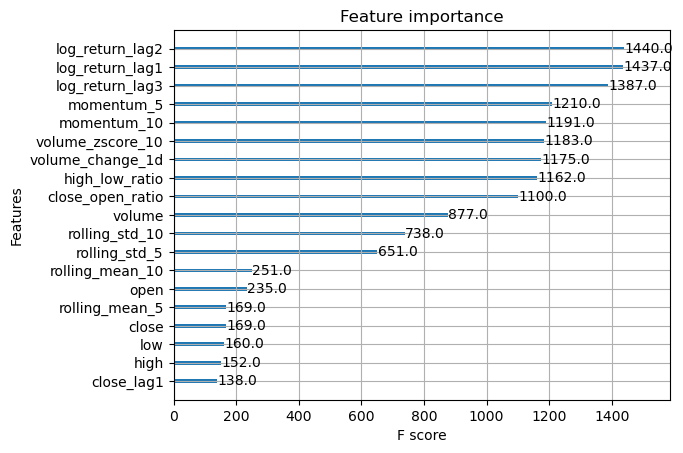

In [82]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_xgb, max_num_features=20)
plt.show()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


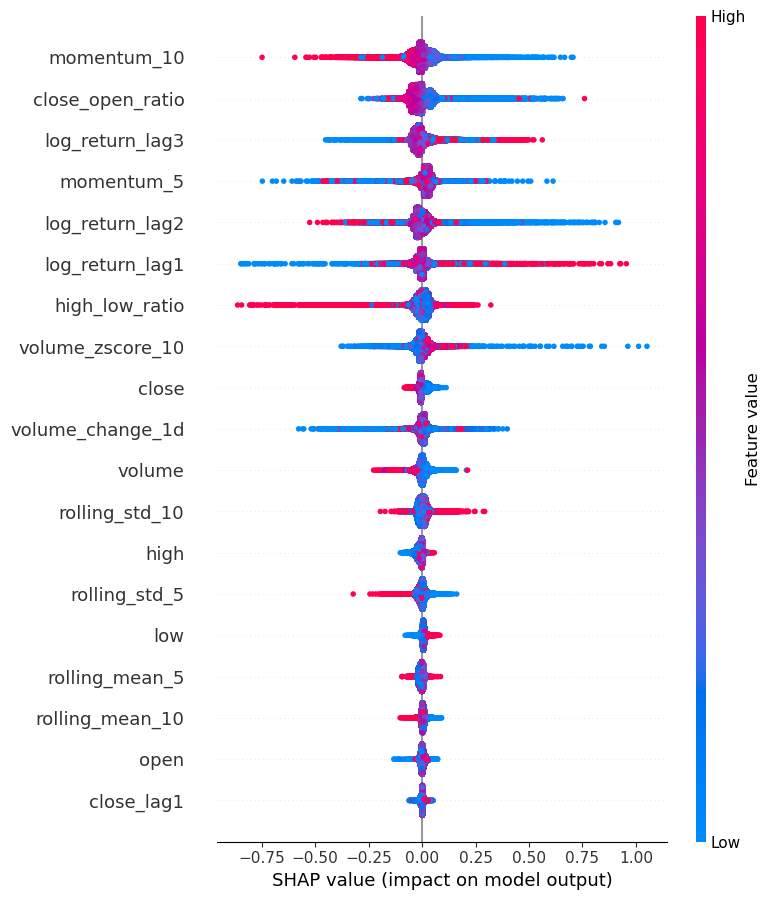

In [81]:
import shap

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)